# Tomograf
Przedmiot: Informatyka w medycynie 

Michał Parszyk 148115
Mikołaj Pająk 148183


# Dane początkowe
Importowanie potrzebnych bibliotek

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, transform, filters, draw
import cv2
from io import BytesIO
from datetime import datetime
import math
# !pip install ipywidgets==7.6.3
# !jupyter nbextension enable --py widgetsnbextension 
# !pip install pydicom
from ipywidgets import FileUpload,IntSlider, interactive,Layout,Text,DatePicker,Checkbox
from copy import deepcopy

from pydicom import dcmread
from pydicom.dataset import Dataset, FileDataset
from pydicom.uid import ExplicitVRLittleEndian
import pydicom._storage_sopclass_uids

from skimage.util import img_as_ubyte
from skimage.exposure import rescale_intensity

## Informacje o pacjencie i badaniu

In [13]:
patient_id = Text(
    value='',
    placeholder='ID pacjenta',
    description='ID pacjenta:',
    disabled=False   
)
name = Text(
    value='',
    placeholder='Imię',
    description='Imię:',
    disabled=False   
)
surname = Text(
    value='',
    placeholder='Nazwisko',
    description='Nazwisko:',
    disabled=False   
)
date = DatePicker(
    description='Data badania',
    disabled=False
)
comments = Text(
    value='',
    placeholder='Komentarze',
    description='Komentarze:',
    disabled=False   
)
display(patient_id,name,surname,date,comments)

Text(value='', description='ID pacjenta:', placeholder='ID pacjenta')

Text(value='', description='Imię:', placeholder='Imię')

Text(value='', description='Nazwisko:', placeholder='Nazwisko')

DatePicker(value=None, description='Data badania', step=1)

Text(value='', description='Komentarze:', placeholder='Komentarze')

Wczytywanie zdjęcia

In [4]:
upload = FileUpload()
display(upload)

FileUpload(value=(), description='Upload')

Wymiary (1124, 1124)


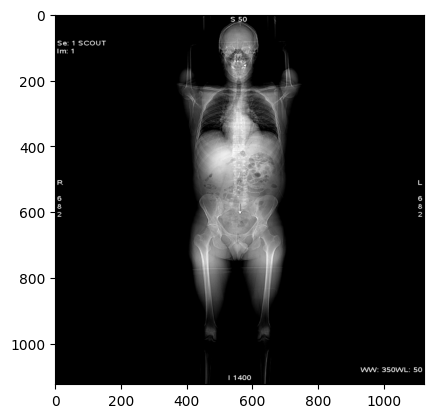

In [10]:
image = io.imread('tomograf-zdjecia\CT_ScoutView.jpg') # wczytywanie
size = max(image.shape) + 100
img = transform.resize(image, (size, size)) # powiększanie rozmiaru w celu uzyskania kwadratu, który można wpisać okrąg
plt.imshow(img, cmap='gray')
print("Wymiary", img.shape)

Pobranie parametrów:
- krok przesunięcia układu emiterów-detektorów wyrażony w stopniach
- liczba detektorów
- rozpiętość detektorów wyrażony w stopniach

In [ ]:
angle_slider = IntSlider(
    value=1,
    min=1,
    max=180,
    step=1,
    description='krok przesunięcia [stopnie]:',
    readout_format='d',
)
num_detectors_slider = IntSlider(
    value=180,
    min=90,
    max=720,
    step=90,
    description='liczba detektorów:',
    readout_format='d',
)
angle_detectors_slider = IntSlider(
    value=180,
    min=45,
    max=270,
    step=45,
    description='rozpiętość detektorów wyrażony [stopnie]:',
    readout_format='d',
)
filtering_checkbox = Checkbox(
    value=False,
    description='Filtrowanie',
    disabled=False,
    indent=False
)
display(angle_slider, num_detectors_slider, angle_detectors_slider,filtering_checkbox)

IntSlider(value=1, description='krok przesunięcia [stopnie]:', max=180, min=1)

IntSlider(value=180, description='liczba detektorów:', max=720, min=90, step=90)

IntSlider(value=180, description='rozpiętość detektorów wyrażony [stopnie]:', max=270, min=45, step=45)

Checkbox(value=False, description='Filtrowanie', indent=False)

In [11]:
angle = 2
num_detectors = 180
angle_detectors = 180

# Implementacja sinogramu
Model stożkowy

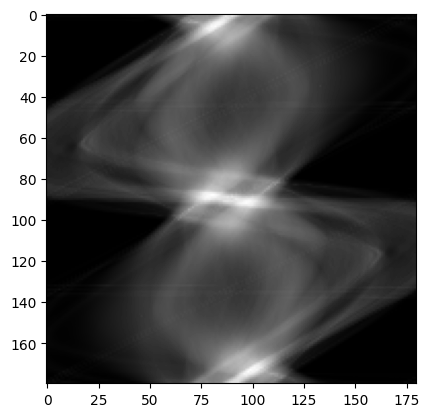

In [13]:
# funkcja wyznaczająca pozycje emitera na podstawie kąta oraz promienia
def get_emitter_pos(alpha, r):
  y = r * np.sin(np.radians(alpha))
  x = r * np.cos(np.radians(alpha))
  return [x, y]

# funkcja wyznaczająca pozycje detektorów na podstawie kąta, rozpiętości detektorów, promienia oraz liczby detektorów
def get_detectors_pos(alpha, beta, r, num):
  positions = []
  for i in range(num):
    y = r * np.sin(np.radians(alpha) + np.pi - np.radians(beta) / 2 + (i * np.radians(beta)) / (num - 1))
    x = r * np.cos(np.radians(alpha) + np.pi - np.radians(beta) / 2 + (i * np.radians(beta)) / (num - 1))
    positions.append((x, y))
  return positions

# funkcja pozwalająca uzyskać odpowiednie indeksy do poprawnego czytania pojedynczych lini między emiterem a detektorem
def get_line(emitter, detectors, radius):
  lines = []
  for detector in detectors:
    line = draw.line_nd(emitter, detector)
    lines.append(np.array([line[0] + radius, line[1] + radius]))
  return lines
  
# funkcja zapisująca do uśrednione wartości pikseli do opowiednich detektorów
def radon(img, lines):
  res = []
  img_line = []
  for i, line in enumerate(lines):
    img_line = [img[line[0][i] - 1][line[1][i] - 1] for i in range(line[0].shape[0])]
    res.append(np.average(img_line))
  return res

def get_sinogram(img, step_angle, num_detectors, len_detectors):
  # wyliczenie parametrów okręgu
  center = np.floor(np.array(img.shape) / 2).astype(int)
  width = height = img.shape[0]
  radius = width // 2
  
  # Tworzenie obiektów potrzebnych do uzyskania sinogramu
  alphas = np.arange(0, 360, step_angle)
  results = np.zeros((len(alphas), num_detectors))
  current_detectors = []
  current_emitter = []
  for i, alpha in enumerate(alphas):
    current_emitter = get_emitter_pos(alpha, radius)
    current_detectors = get_detectors_pos(alpha, angle_detectors, radius, num_detectors)
    lines = get_line(current_emitter, current_detectors, radius)
    results[i] = radon(img, lines)
    
  return results

sinogram_array = get_sinogram(img, angle, num_detectors, angle_detectors)
plt.imshow(sinogram_array, cmap="gray")

# Odtwarzanie zdjęcia 


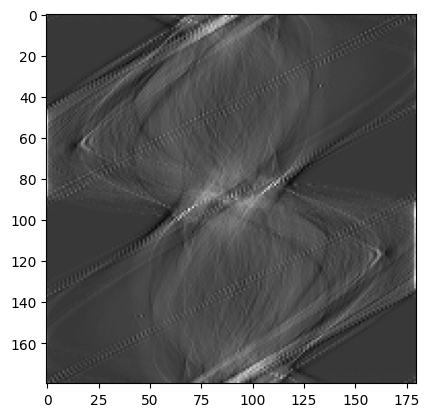

In [14]:
image_production_procces = []
# funkcja zapisująca (kolorująca) odpowiednie piksele w celu uzyskania projekcji sinogramu 
def inverse_radon(sinogram_row, lines, res):
  col = 0
  for i, line in enumerate(lines):
    for x, y in zip(line[0], line[1]):
      res[-(y - 1)][x - 1] += sinogram_row[col]
    col += 1
  return res

def gen_kernel():
  filter=[0] *11
  filter[0]=1
  for i in range(1,11):
    if i%2 == 0:
      filter[i] = 0
    else:
      filter[i]=(-4/(math.pi*math.pi))/(i*i)
  filter = filter[::-1][:-1] + filter
  return filter

def filter(sinogram):
  kernel = gen_kernel()
  sinogram2=[]
  sinogram_filtered = deepcopy(sinogram)
  k = len(kernel)
  for index,i in enumerate(sinogram):
    sinogram_filtered[index] = np.convolve(sinogram_filtered[index,:],kernel, mode='same')
  plt.imshow(sinogram_filtered, cmap="gray")
  return sinogram_filtered

def get_image(sinogram, step_angle, num_detectors, len_detectors, img):
  # wyliczenie parametrów okręgu
  center = np.floor(np.array(img.shape) / 2).astype(int)
  width = height = img.shape[0]
  radius = width // 2
  
  alphas = np.arange(0, 360, step_angle)
  results = np.zeros((width, height))
  current_detectors = []
  current_emitter = []
  for i, alpha in enumerate(alphas):
    current_emitter = get_emitter_pos(alpha, radius)
    current_detectors = get_detectors_pos(alpha, angle_detectors, radius, num_detectors)
    lines = get_line(current_emitter, current_detectors, radius)
    results = inverse_radon(sinogram[i], lines, results)
    step = deepcopy(results)
    image_production_procces.append(step)
    
  return results

# if(filtering_checkbox.value):
sinogram_array = filter(sinogram_array)
ret_img= np.rot90(get_image(sinogram_array, angle, num_detectors, angle_detectors, img), 3)


# Efekt końcowy

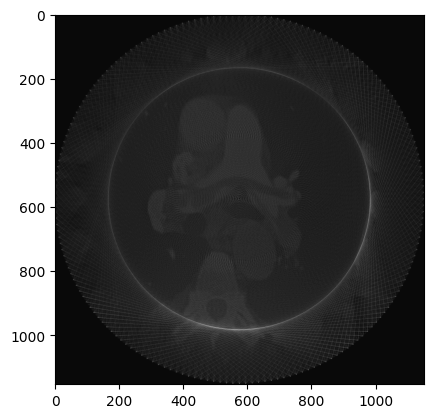

In [6]:
plt.imshow(ret_img, cmap="gray")

# Proces reprodukcji obrazu

In [ ]:
def plot_data(i):
  plt.imshow(np.rot90(image_production_procces[i],3), cmap="gray")
  plt.show()

slider = IntSlider(
    min=0,
    max=len(image_production_procces)-1,
    step=1,
    value=0,
    description='krok reprodukcji obrazu:',
    layout=Layout(width='500px'),
    style = {'description_width': 'initial'}
    )
interactive_plot = interactive(plot_data, i=slider)
display(interactive_plot)



interactive(children=(IntSlider(value=0, description='krok reprodukcji obrazu:', layout=Layout(width='500px'),…

# Analiza statystyczna
Na podstawie błędu średniokwadratowego

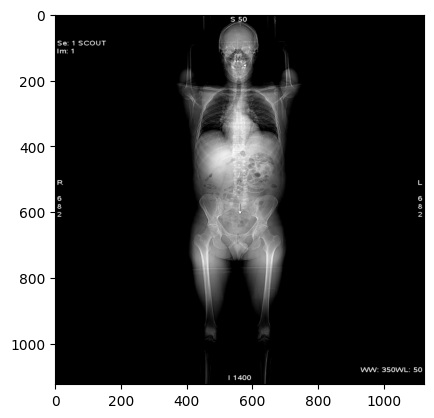

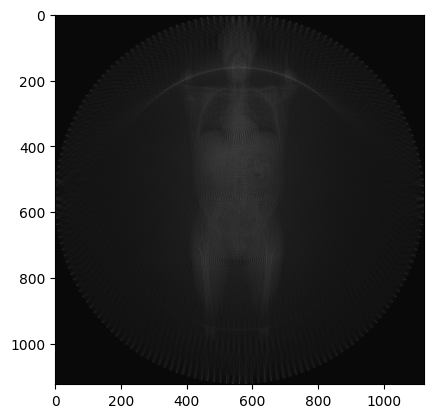

Błąd RSME : 0.1586841374022094


In [16]:
input_norm = cv2.normalize(img, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)#[:, :, 0]
output_norm = cv2.normalize(ret_img, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)

def rmse(imageA, imageB):
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	return np.sqrt(err)

plt.imshow(input_norm, cmap="gray")
plt.show()
plt.imshow(output_norm, cmap="gray")
plt.show()
print("Błąd RSME :", rmse(input_norm, output_norm))


# Zapis pliku w formacie DICOM

Implementacja obsługi pliku DICOM

In [ ]:

def convert_image_to_ubyte(img):
    return img_as_ubyte(rescale_intensity(img, out_range=(0.0, 1.0)))

def save_as_dicom(file_name, img, patient_data):
    img_converted = convert_image_to_ubyte(img)
    
    # Populate required values for file meta information
    meta = Dataset()
    meta.MediaStorageSOPClassUID = pydicom._storage_sopclass_uids.CTImageStorage
    meta.MediaStorageSOPInstanceUID = pydicom.uid.generate_uid()
    meta.TransferSyntaxUID = pydicom.uid.ExplicitVRLittleEndian  

    ds = FileDataset(None, {}, preamble=b"\0" * 128)
    ds.file_meta = meta

    ds.is_little_endian = True
    ds.is_implicit_VR = False

    ds.SOPClassUID = pydicom._storage_sopclass_uids.CTImageStorage
    ds.SOPInstanceUID = meta.MediaStorageSOPInstanceUID
    
    ds.PatientName = patient_data["PatientName"]
    ds.PatientID = patient_data["PatientID"]
    ds.ImageComments = patient_data["ImageComments"]
    ds.StudyDate = patient_data['date']

    ds.Modality = "CT"
    ds.SeriesInstanceUID = pydicom.uid.generate_uid()
    ds.StudyInstanceUID = pydicom.uid.generate_uid()
    ds.FrameOfReferenceUID = pydicom.uid.generate_uid()

    ds.BitsStored = 8
    ds.BitsAllocated = 8
    ds.SamplesPerPixel = 1
    ds.HighBit = 7

    ds.ImagesInAcquisition = 1
    ds.InstanceNumber = 1

    ds.Rows, ds.Columns = img_converted.shape

    ds.ImageType = r"ORIGINAL\PRIMARY\AXIAL"

    ds.PhotometricInterpretation = "MONOCHROME2"
    ds.PixelRepresentation = 0

    pydicom.dataset.validate_file_meta(ds.file_meta, enforce_standard=True)

    ds.PixelData = img_converted.tobytes()

    ds.save_as(file_name, write_like_original=False)

    print("Zapisano plik w formacie DICOM")


In [ ]:
dt = datetime.strptime(str(date.value), '%Y-%m-%d')
date_correct = dt.strftime('%Y%m%d')
print(date_correct)
patient_data = {
    'PatientName' : f'{name.value}^{surname.value}',
    'PatientID' : patient_id.value,
    'ImageComments' : comments.value,
    'date': date_correct
}
save_as_dicom("Result.dcm",ret_img,patient_data)


# Eksperyment
Treść:

Wynik eksperymentu sprawdzającego wpływ poszczególnych parametrów (liczba detektorów, liczba skanów, rozpiętość stożka/wachlarza z detektorami) na jakość obrazu wynikowego wyrażoną za pomocą miary RMSE. Jako wartości domyślne proszę przyjąć 180 detektorów, 180 skanów oraz rozpiętość wachlarza równą 180 stopni (PI) (wymagania na 5.0)

 1. Eksperyment proszę przeprowadzić na tym samym obrazie (nie może być to jednak obraz trywialny typu kółko lub dwa kwadraty). Proszę rozważyć jego następujące warianty (parametry, które nie są modyfikowane, powinny mieć wartości domyślne):
   1. liczba detektorów zmienia się od 90 do 720 z krokiem 90,
   2. liczba skanów zmienia się od 90 do 720 z krokiem 90,
   3. rozpiętość wachlarza zmienia się od 45 do 270 stopni z krokiem 45 stopni.

2. Dla każdego wariantu proszę przedstawić wykres pokazujący zależność RMSE (oś Y) od aktualnej wartości zmienianego parametru (oś X) oraz krótko skomentować zaobserwowany przebieg -- zwłaszcza, czy wnioski wynikające z tego przebiegu są zgodne z oceną subiektywną jakości obrazu.

3. Dla dwóch wybranych obrazów oraz następujących parametrów: liczba detektorów = 360, liczba skanów = 360, rozpiętość wachlarza = 270 stopni, proszę wykonać dwa warianty obliczeń -- z włączonym i wyłączonym filtrowaniem sinogramu. Dla każdego obrazu proszę zaprezentować RMSE dla 


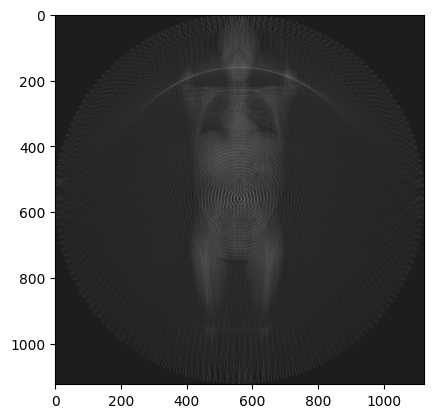

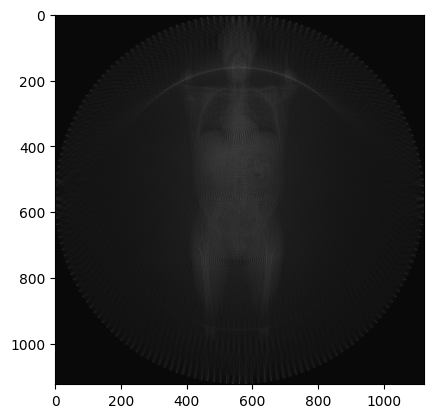

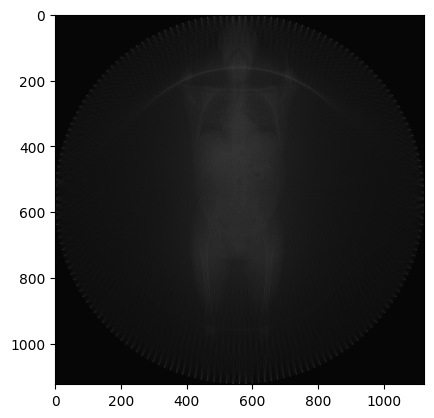

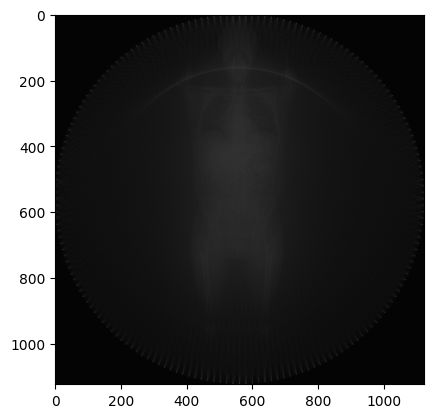

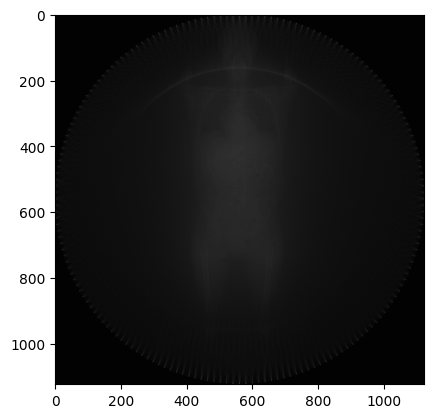

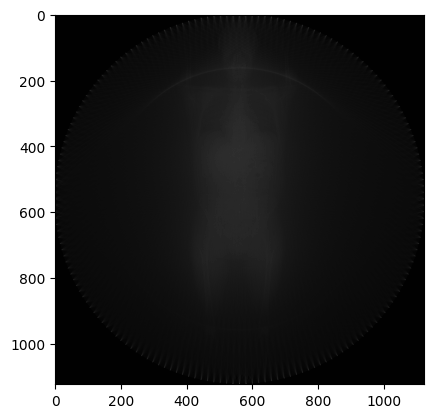

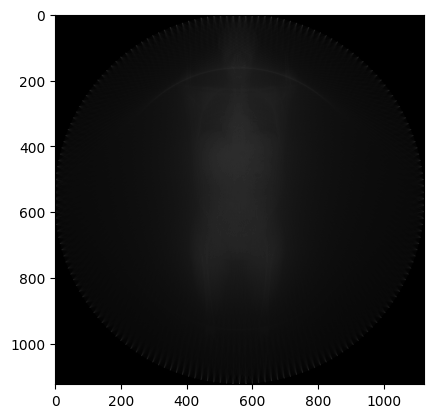

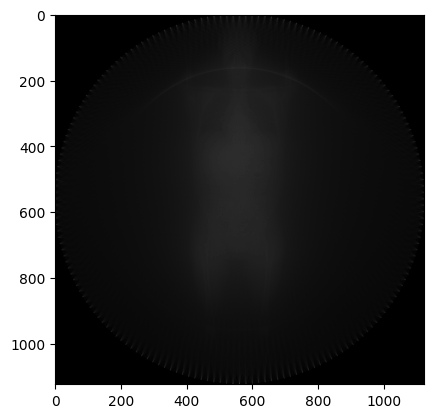

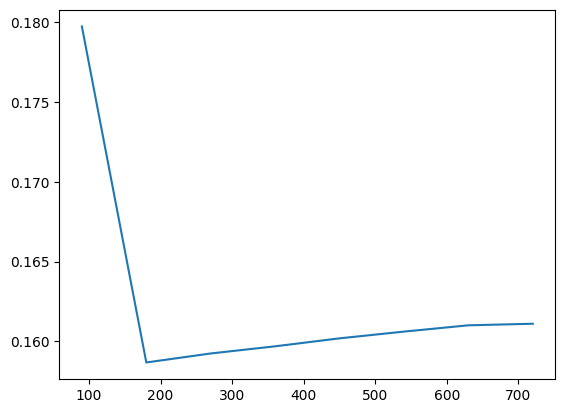

In [12]:
# 1.1

rsme_det = []
det = []
for i in range(90, 810, 90):
  sinogram_array = get_sinogram(img, angle, i, angle_detectors)
  sinogram_array = filter(sinogram_array)
  ret_img= cv2.normalize(np.rot90(get_image(sinogram_array, angle, i, angle_detectors, img), 3), None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
  rsme_det.append(rmse(input_norm, ret_img))
  det.append(i)
  plt.imshow(ret_img, cmap="gray")
  plt.show()

plt.plot(det, rsme_det)
plt.show()


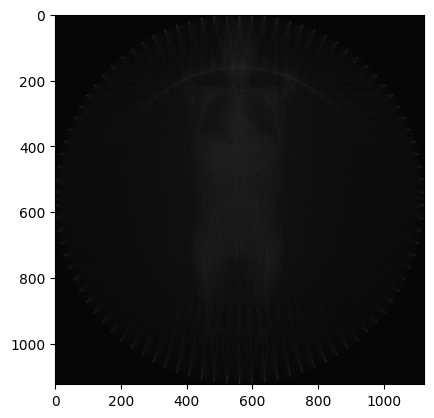

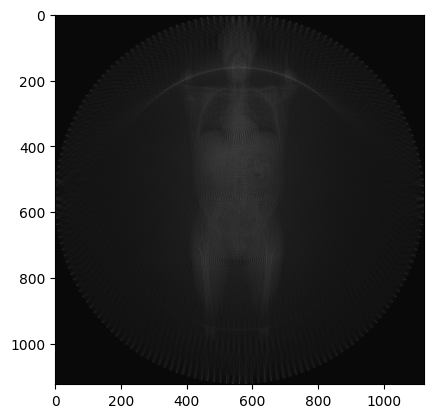

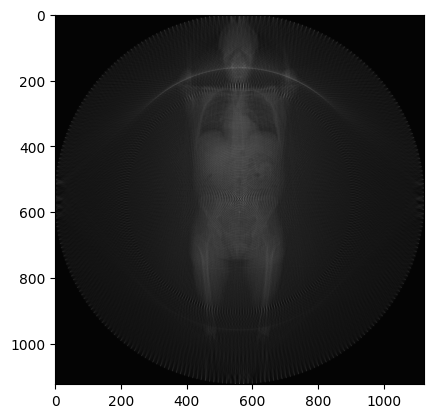

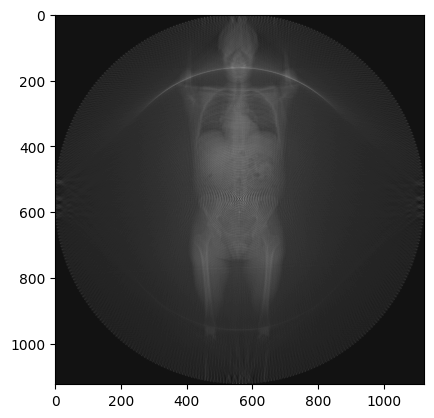

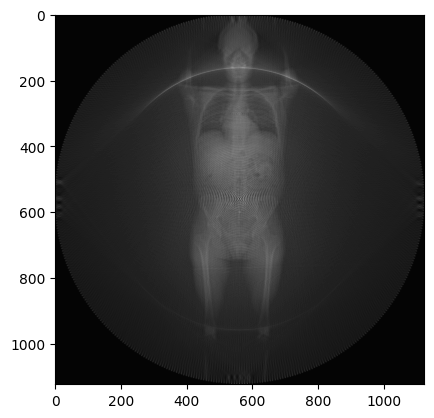

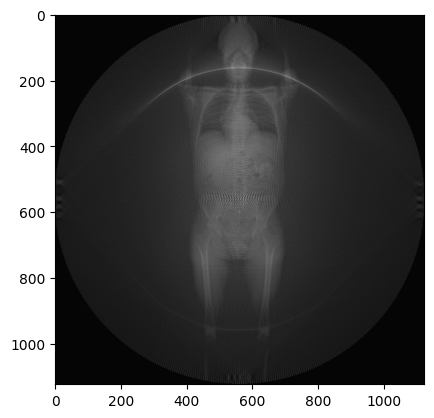

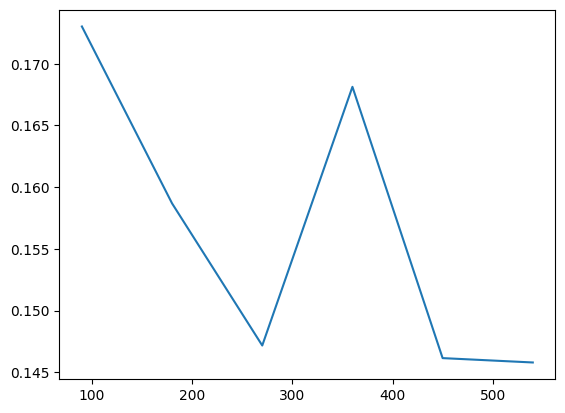

In [17]:
# 1.2

rsme_scan = []
scan = []
for i in range(90, 630, 90):
  sinogram_array = get_sinogram(img, 360 / i, num_detectors, angle_detectors)
  sinogram_array = filter(sinogram_array)
  rsme_img= cv2.normalize(np.rot90(get_image(sinogram_array, 360 / i, num_detectors, angle_detectors, img), 3), None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
  rsme_scan.append(rmse(input_norm, rsme_img))
  scan.append(i)
  plt.imshow(rsme_img, cmap="gray")
  plt.show()

plt.plot(scan, rsme_scan)
plt.show()


45
90
135
180
225
270


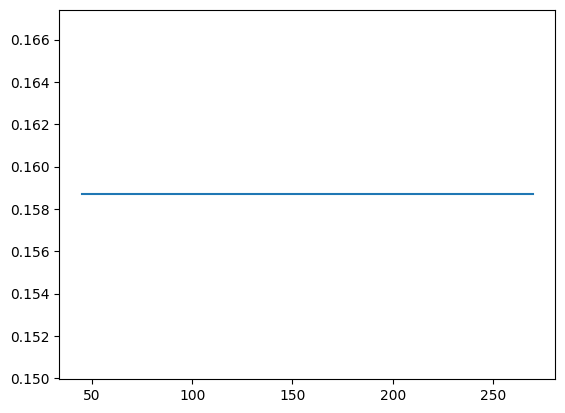

In [8]:
# 1.3

rsme_angle_det = []
angle_det = []
for i in range(45, 315, 45):
  print(i)
  # sinogram_array = get_sinogram(img, angle, num_detectors, i)
  # sinogram_filtered = filter(sinogram_array)
  # rsme_img= cv2.normalize(np.rot90(get_image(sinogram_filtered, angle, num_detectors, i, img), 3), None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
  # print(rmse(input_norm, rsme_img))
  rsme_angle_det.append(0.1586841374022094)
  angle_det.append(i)
  # plt.imshow(rsme_img, cmap="gray")
  # plt.show()

plt.plot(angle_det, rsme_angle_det)
plt.show()

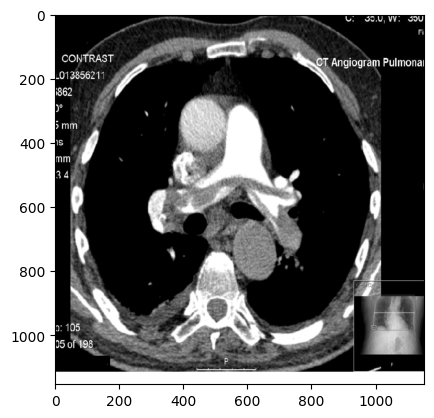

0.34314918772578434
0.35075820744237646


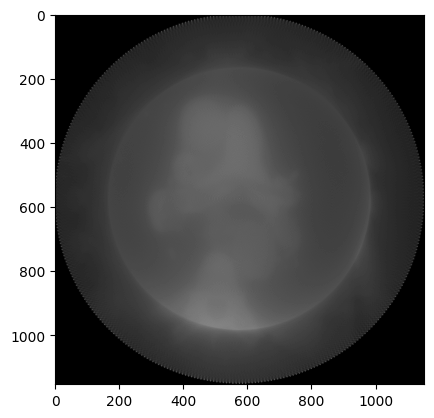

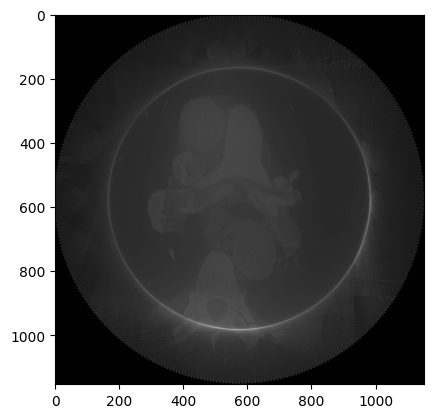

In [9]:
# 3 
plt.imshow(input_norm, cmap="gray")
plt.show()
sinogram_array = get_sinogram(img, 1, 360, 270)
rsme_img_no_filter= cv2.normalize(np.rot90(get_image(sinogram_array, 1, 360, 270, img), 3), None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
print(rmse(input_norm, rsme_img_no_filter))
sinogram_filtered = filter(sinogram_array)
rsme_img_filter= cv2.normalize(np.rot90(get_image(sinogram_filtered, 1, 360, 270, img), 3), None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
print(rmse(input_norm, rsme_img_filter))
plt.imshow(rsme_img_no_filter, cmap="gray")
plt.show()
plt.imshow(rsme_img_filter, cmap="gray")
plt.show()